In [ ]:
!pip install kaggle==1.5.12

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 59.0/59.0 kB 5.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for kaggle: filename=kaggle-1.5.12-py3-none-any.whl size=73026 sha256=16a404814993094877d3f4c472746b9ea5ca2d02130bc42e6c20d100289f0463
  Stored in directory: /root/.cache/pip/wheels/70/0c/e6/79103212a102e78b8453691b905f48000219574ba7137e7207
Successfully built kaggle
  Attempting uninstall: kaggle
    Found existing installation: kaggle 1.6.17
    Uninstalling kaggle-1.6.17:
      Successfully uninstalled kaggle-1.6.17


In [ ]:
!mkdir -p ~/.kaggle
!cp /content/drive/MyDrive/Drowsiness/kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [ ]:
!kaggle datasets download -d ismailnasri20/driver-drowsiness-dataset-ddd -p /content/drive/MyDrive/Drowsiness/Dataset

100% 2.58G/2.58G [00:32<00:00, 104MB/s] 
100% 2.58G/2.58G [00:33<00:00, 83.9MB/s]


In [ ]:
!unzip /content/drive/MyDrive/Drowsiness/Dataset/driver-drowsiness-dataset-ddd.zip -d /content/drive/MyDrive/Drowsiness/Dataset/


Streaming output truncated to the last 5000 lines.
  inflating: /content/drive/MyDrive/Drowsiness/Dataset/Driver Drowsiness Dataset (DDD)/Non Drowsy/y0082.png  
  inflating: /content/drive/MyDrive/Drowsiness/Dataset/Driver Drowsiness Dataset (DDD)/Non Drowsy/y0083.png  
  inflating: /content/drive/MyDrive/Drowsiness/Dataset/Driver Drowsiness Dataset (DDD)/Non Drowsy/y0084.png  
  inflating: /content/drive/MyDrive/Drowsiness/Dataset/Driver Drowsiness Dataset (DDD)/Non Drowsy/y0085.png  
  inflating: /content/drive/MyDrive/Drowsiness/Dataset/Driver Drowsiness Dataset (DDD)/Non Drowsy/y0086.png  
  inflating: /content/drive/MyDrive/Drowsiness/Dataset/Driver Drowsiness Dataset (DDD)/Non Drowsy/y0087.png  
  inflating: /content/drive/MyDrive/Drowsiness/Dataset/Driver Drowsiness Dataset (DDD)/Non Drowsy/y0088.png  
  inflating: /content/drive/MyDrive/Drowsiness/Dataset/Driver Drowsiness Dataset (DDD)/Non Drowsy/y0089.png  
  inflating: /content/drive/MyDrive/Drowsiness/Dataset/Driver Drowsin

# Visualize

In [5]:
import os
import cv2
from collections import defaultdict
import random
import matplotlib.pyplot as plt
from tensorflow import keras

In [ ]:
def get_unique_image_sizes_cv2(filepath):
  """
  Returns a dictionary of unique image sizes and their counts in a filepath using cv2.

  Args:
    filepath: The path to the directory containing images.

  Returns:
    A dictionary where keys are image sizes (tuples of width, height)
    and values are the number of images with that size.
  """
  unique_sizes = defaultdict(int)
  for root, _, files in os.walk(filepath):
    for file in files:
      if file.lower().endswith(('.png', '.jpg', '.jpeg')):
        image_path = os.path.join(root, file)
        try:
          img = cv2.imread(image_path)
          height, width, _ = img.shape  # Get image dimensions
          size = (width, height)
          unique_sizes[size] += 1
        except cv2.error as e:
          print(f"Error reading image: {image_path}, Error: {e}")
  return unique_sizes

# Example usage
filepath = "/content/drive/MyDrive/Drowsiness/Dataset/DDD/Drowsy"  # Replace with your filepath
unique_sizes = get_unique_image_sizes_cv2(filepath)

print("Unique image sizes and their counts:")
for size, count in unique_sizes.items():
  print(f"Size: {size}, Count: {count}")

KeyboardInterrupt: 

In [42]:
DROWNSY_PATH = "/content/drive/MyDrive/Drowsiness/Dataset/DDD/Drowsy"
NON_DROWNSY_PATH = "/content/drive/MyDrive/Drowsiness/Dataset/DDD/Non_Drowsy"
WIDTH, HEIGHT = (112, 112)
BATCH_SIZE = 128
EPOCHS = 10
LR_PRETRAINED = 0.001
LR_TOP = 0.001
initializer = keras.initializers.glorot_normal()

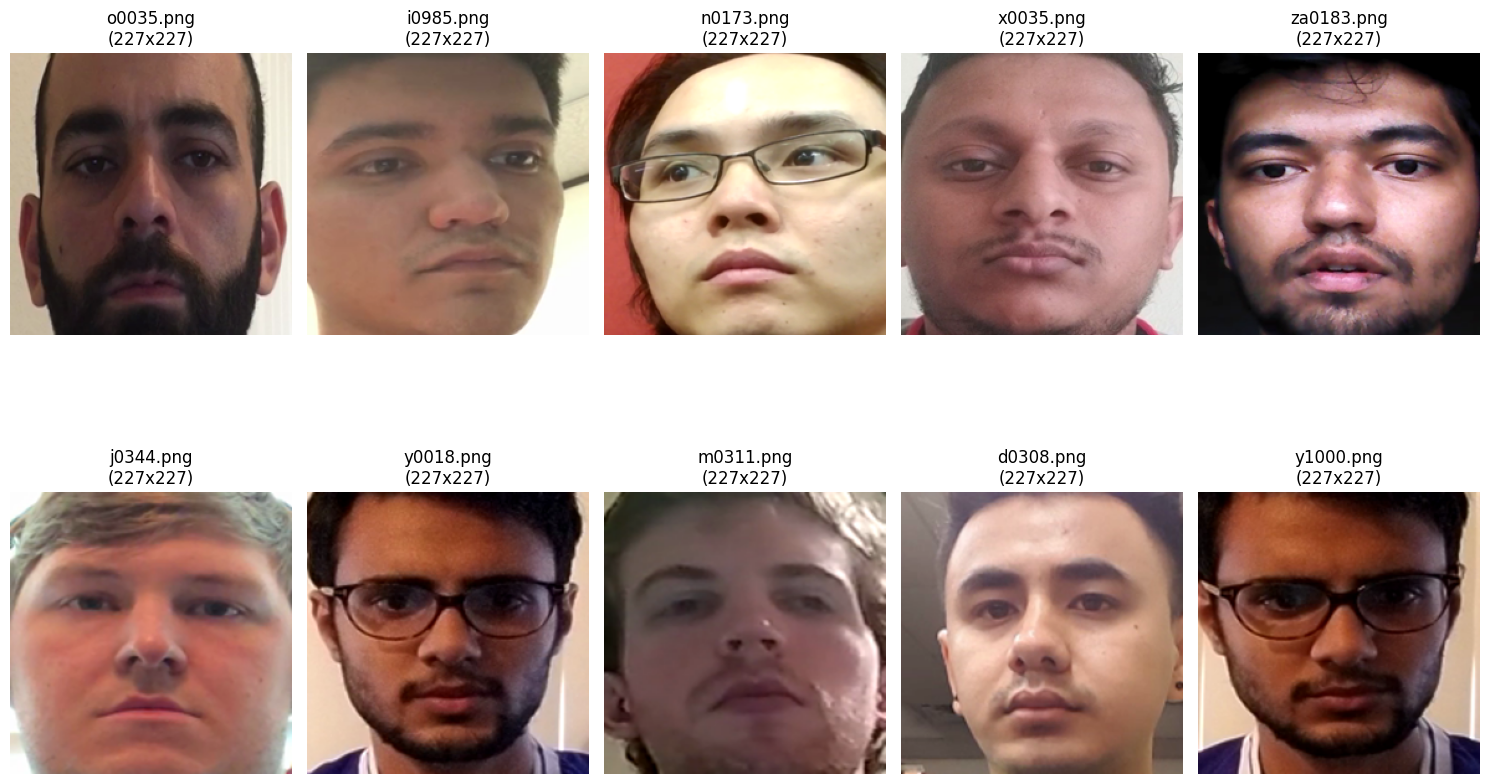

In [ ]:
def show_random_images(filepath, num_images=10):
    """
    Displays a specified number of random images from a filepath.

    Args:
        filepath: The path to the directory containing images.
        num_images: The number of random images to display (default is 10).
    """
    image_files = [
        os.path.join(root, file)
        for root, _, files in os.walk(filepath)
        for file in files
        if file.lower().endswith(('.png', '.jpg', '.jpeg'))
    ]

    if not image_files:
        print(f"No image files found in {filepath}")
        return

    random_images = random.sample(image_files, min(num_images, len(image_files)))

    plt.figure(figsize=(15, 10))  # Adjust figure size as needed
    for i, image_path in enumerate(random_images):
        img = cv2.imread(image_path)
        height, width, _ = img.shape
        img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        plt.subplot(2, 5, i + 1)
        plt.imshow(img_rgb)
        plt.title(f"{os.path.basename(image_path)}\n({width}x{height})")  # Add size to title
        plt.axis('off')
    plt.tight_layout()
    plt.show()

# Example usage:
show_random_images(NON_DROWNSY_PATH)

# DATA PREPARATION

*   **DROWNSY: 1**
*   **NON_DROWNSY: 0**

In [16]:
import pandas as pd
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
from sklearn.utils import resample
from imblearn.under_sampling import RandomUnderSampler



In [9]:
def create_dataframe(drowsy_dir, nondrowsy_dir):
    """
    Creates a Pandas DataFrame with file paths and labels for Drowsy and NonDrowsy images.

    Args:
        drowsy_dir: Path to the directory containing Drowsy images.
        nondrowsy_dir: Path to the directory containing NonDrowsy images.

    Returns:
        A Pandas DataFrame with columns 'image_path' and 'label'.
    """
    image_paths = []
    labels = []

    # Get Drowsy image paths and labels
    for filename in os.listdir(drowsy_dir):
        if filename.endswith(('.png', '.jpg', '.jpeg')):
            image_paths.append(os.path.join(drowsy_dir, filename))
            labels.append("Drownsy")  # or 1 if you want numerical labels

    # Get NonDrowsy image paths and labels
    for filename in os.listdir(nondrowsy_dir):
        if filename.endswith(('.png', '.jpg', '.jpeg')):
            image_paths.append(os.path.join(nondrowsy_dir, filename))
            labels.append("Non-Drownsy")  # or 0 if you want numerical labels

    # Create DataFrame
    df = pd.DataFrame({'image_path': image_paths, 'label': labels})
    return df

# Example usage

df = create_dataframe(DROWNSY_PATH, NON_DROWNSY_PATH)


In [19]:
class_counts = df['label'].value_counts()
print("Class balance in train_df:\n", class_counts)

Class balance in train_df:
 label
Drownsy        22348
Non-Drownsy    19445
Name: count, dtype: int64


In [20]:
def get_fixed_instances_per_class(df, num_instances_per_class):
  """Gets a fixed number of instances for each class from the DataFrame.

  Args:
    df: The input Pandas DataFrame with 'label' column.
    num_instances_per_class: The desired number of instances for each class.

  Returns:
    A DataFrame with a fixed number of instances per class.
  """
  balanced_df = df.groupby('label', group_keys=False).apply(lambda x: x.sample(min(len(x), num_instances_per_class), random_state=42))
  return balanced_df

# Example usage:
balanced_df = get_fixed_instances_per_class(df, 19400)

<ipython-input-20-67e1ec0c79a2>:11: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  balanced_df = df.groupby('label', group_keys=False).apply(lambda x: x.sample(min(len(x), num_instances_per_class), random_state=42))


In [21]:
class_counts = balanced_df['label'].value_counts()
print("Class balance in train_df:\n", class_counts)

Class balance in train_df:
 label
Drownsy        19400
Non-Drownsy    19400
Name: count, dtype: int64


In [25]:
def split_and_save_dataframe(df, train_csv_path, val_csv_path, test_csv_path, test_size=0.2, random_state=42):
    """
    Splits a DataFrame into training and testing sets and saves them as CSV files.

    Args:
        df: The input Pandas DataFrame.
        train_csv_path: Path to save the training data CSV file.
        test_csv_path: Path to save the testing data CSV file.
        test_size: Proportion of the dataset to include in the test split (default is 0.2).
        random_state: Controls the shuffling applied to the data before applying the split (default is 42).
    """
    val_train_df, test_df = train_test_split(df, test_size=test_size, stratify=df['label'], random_state=random_state)

    train_df, val_df = train_test_split(val_train_df, test_size=test_size, stratify=val_train_df['label'], random_state=random_state)  # Adjust test_size as needed


    train_df.to_csv(train_csv_path, index=False)
    val_df.to_csv(val_csv_path, index=False)
    test_df.to_csv(test_csv_path, index=False)


# Example usage
# Assuming you have the DataFrame 'df' from the previous step
train_csv_path = '/content/drive/MyDrive/Drowsiness/Dataset/Output/train.csv'
val_csv_path = '/content/drive/MyDrive/Drowsiness/Dataset/Output/val.csv'
test_csv_path = '/content/drive/MyDrive/Drowsiness/Dataset/Output/test.csv'

split_and_save_dataframe(balanced_df, train_csv_path, val_csv_path, test_csv_path)

In [26]:
train_csv_path = '/content/drive/MyDrive/Drowsiness/Dataset/Output/train.csv'
val_csv_path = '/content/drive/MyDrive/Drowsiness/Dataset/Output/val.csv'

# Load the DataFrames
train_df = pd.read_csv(train_csv_path)
val_df = pd.read_csv(val_csv_path)


# Assuming you have your DataFrames: train_df, val_df, test_df

# Check the size of train_df
train_size = train_df.shape
print("Train DataFrame size:", train_size)

# Check the size of val_df
val_size = val_df.shape
print("Validation DataFrame size:", val_size)

# Check the size of test_df (if you have it)
# test_size = test_df.shape
# print("Test DataFrame size:", test_size)

Train DataFrame size: (24832, 2)
Validation DataFrame size: (6208, 2)


In [27]:
# Check class balance in train_df
train_class_counts = train_df['label'].value_counts()
print("Class balance in train_df:\n", train_class_counts)

# Check class balance in val_df
val_class_counts = val_df['label'].value_counts()
print("\nClass balance in val_df:\n", val_class_counts)

Class balance in train_df:
 label
Drownsy        12416
Non-Drownsy    12416
Name: count, dtype: int64

Class balance in val_df:
 label
Non-Drownsy    3104
Drownsy        3104
Name: count, dtype: int64


In [44]:
def create_datagen_dataframe(train_df, val_df, img_size, batch_size):
  """
  Creates data generators for training and validation using flow_from_dataframe.

  Args:
    train_df: Pandas DataFrame containing training data (image paths and labels).
    val_df: Pandas DataFrame containing validation data (image paths and labels).
    img_size: Target size for resizing images (e.g., (224, 224)).
    batch_size: Batch size for the data generators.

  Returns:
    A tuple containing the training and validation data generators.
  """
  train_datagen = ImageDataGenerator(
      rescale=1./255,
      rotation_range=20,
      width_shift_range=0.2,
      height_shift_range=0.2,
      shear_range=0.2,
      zoom_range=0.2,
      horizontal_flip=True,
      fill_mode='nearest'
  )

  val_datagen = ImageDataGenerator(rescale=1./255)

  train_generator = train_datagen.flow_from_dataframe(
      dataframe=train_df,
      directory=None,  # Set to None if image paths are absolute
      x_col='image_path',  # Column name containing image paths
      y_col='label',  # Column name containing labels
      target_size=img_size,
      batch_size=batch_size,
      class_mode='binary',  # or 'binary', 'sparse', etc.
  )

  val_generator = val_datagen.flow_from_dataframe(
      dataframe=val_df,
      directory=None,
      x_col='image_path',
      y_col='label',
      target_size=img_size,
      batch_size=batch_size,
      class_mode='binary',

  )

  return train_generator, val_generator

# ARCHITECTURE

In [45]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import ModelCheckpoint


In [48]:
# pretrained_model = keras.applications.EfficientNetB0(
#     include_top = False,
#     weights=None,
#     input_tensor=(WIDTH, HEIGHT, 3),
#     name="efficientnetb0",
#     pooling = 'avg',
# )

ValueError: Argument `input_tensor` must be a KerasTensor. Received invalid type: input_tensor=(112, 112, 3) (of type <class 'tuple'>)

In [62]:
pretrained_model = keras.applications.MobileNetV2(
    input_shape=(112, 112, 3), include_top=False, weights=None, pooling='avg'
)

In [63]:
pretrained_model.summary()

Model: "mobilenetv2_1.00_112"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_9             │ (None, 112, 112, 3)    │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ Conv1 (Conv2D)            │ (None, 56, 56, 32)     │            864 │ input_layer_9[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ bn_Conv1                  │ (None, 56, 56, 32)     │            128 │ Conv1[0][0]            │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ Conv1_relu (ReLU)         │ (None, 56, 56, 32)     │              0 │ bn_Conv1[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_depthwise   │ (None, 56, 56, 32)     │            288 │ Conv1_relu[0][0]       │
│ (DepthwiseConv2D)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_depthwise_… │ (None, 56, 56, 32)     │            128 │ expanded_conv_depthwi… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_depthwise_… │ (None, 56, 56, 32)     │              0 │ expanded_conv_depthwi… │
│ (ReLU)                    │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_project     │ (None, 56, 56, 16)     │            512 │ expanded_conv_depthwi… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_project_BN  │ (None, 56, 56, 16)     │             64 │ expanded_conv_project… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_expand (Conv2D)   │ (None, 56, 56, 96)     │          1,536 │ expanded_conv_project… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_expand_BN         │ (None, 56, 56, 96)     │            384 │ block_1_expand[0][0]   │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_expand_relu       │ (None, 56, 56, 96)     │              0 │ block_1_expand_BN[0][… │
│ (ReLU)                    │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_pad               │ (None, 57, 57, 96)     │              0 │ block_1_expand_relu[0… │
│ (ZeroPadding2D)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_depthwise         │ (None, 28, 28, 96)     │            864 │ block_1_pad[0][0]      │
│ (DepthwiseConv2D)         │                        │                │                        │
├──────────────────────

 Total params: 2,257,984 (8.61 MB)

 Trainable params: 2,223,872 (8.48 MB)

 Non-trainable params: 34,112 (133.25 KB)

In [64]:
def create_model(input_shape, base_model):
    """
    Creates a model by flattening the output of a pre-trained model and adding dense layers.

    Args:
        input_shape: The shape of the input images.
        num_classes: The number of classes for the classification task.
        pretrained_model: The pre-trained model to use.

    Returns:
        The compiled Keras model.
    """
    # Load the pre-trained model

    # Freeze the base model layers
    # base_model.trainable = False

    # Create the input layer
    inputs = keras.Input(shape=input_shape)

    # Pass the inputs through the base model
    x = base_model(inputs)
    # x = layers.MaxPooling2D(pool_size=(2, 2))(x)

    # Add dense layers
    x = layers.Dense(1024, activation='relu', kernel_regularizer=keras.regularizers.l2(0.05), kernel_initializer=initializer)(x)
    x = layers.Dropout(0.2)(x)
    x = layers.Dense(256, activation='relu', kernel_regularizer=keras.regularizers.l2(0.05), kernel_initializer=initializer)(x)
    x = layers.Dropout(0.2)(x)
    outputs = layers.Dense(1, activation='sigmoid')(x)

    # Create the model
    model = keras.Model(inputs, outputs)

    return model

# Example usage:
input_shape = (WIDTH, HEIGHT, 3)  # Example input shape

model = create_model(input_shape, pretrained_model)
model.summary()

Model: "functional_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_10 (InputLayer)          │ (None, 112, 112, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ mobilenetv2_1.00_112 (Functional)    │ (None, 1280)                │       2,257,984 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_12 (Dense)                     │ (None, 1024)                │       1,311,744 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_8 (Dropout)                  │ (None, 1024)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_13 (Dense)                     │ (None, 256)                 │         262,400 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_9 (Dropout)                  │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_14 (Dense)                     │ (None, 1)                   │             257 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 3,832,385 (14.62 MB)

 Trainable params: 3,798,273 (14.49 MB)

 Non-trainable params: 34,112 (133.25 KB)

In [65]:
# Alternative: use a custom initializer
initializer = keras.initializers.GlorotNormal()
for layer in model.layers:
  if isinstance(layer, (keras.layers.Dense, keras.layers.Conv2D)):
    layer.kernel_initializer = initializer
    layer.bias_initializer = 'zeros'  # Optional: set bias initializer to zeros

In [ ]:
# def create_model(input_shape):
#     """
#     Creates a model by flattening the output of a pre-trained model and adding dense layers.

#     Args:
#         input_shape: The shape of the input images.
#         num_classes: The number of classes for the classification task.
#         pretrained_model: The pre-trained model to use.

#     Returns:
#         The compiled Keras model.
#     """
#     # Load the pre-trained model

#     # Freeze the base model layers
#     # base_model.trainable = False

#     # Create the input layer
#     inputs = keras.Input(shape=input_shape)

#     # Pass the inputs through the base model
#     x = layers.output(inputs)
#     # x = layers.MaxPooling2D(pool_size=(2, 2))(x)

#     # Add dense layers
#     x = layers.Dense(1024, activation='relu', kernel_regularizer=keras.regularizers.l2(0.05), kernel_initializer=initializer)(x)
#     x = layers.Dropout(0.2)(x)
#     x = layers.Dense(256, activation='relu', kernel_regularizer=keras.regularizers.l2(0.05), kernel_initializer=initializer)(x)
#     x = layers.Dropout(0.2)(x)
#     outputs = layers.Dense(1, activation='sigmoid')(x)

#     # Create the model
#     model = keras.Model(inputs, outputs)

#     return model

# # Example usage:
# input_shape = (WIDTH, HEIGHT, 3)  # Example input shape

# model = create_model(input_shape, pretrained_model)
# model.summary()

# TRAINING

In [66]:
train_generator, val_generator = create_datagen_dataframe(train_df, val_df, (WIDTH, HEIGHT), BATCH_SIZE)
# train_generator, val_generator = create_datagen_dataframe(train_df_subset, val_df_subset, (WIDTH, HEIGHT), BATCH_SIZE)


Found 24832 validated image filenames belonging to 2 classes.
Found 6208 validated image filenames belonging to 2 classes.


In [57]:
import numpy as np

def check_batch_balance(generator):
  """
  Checks and prints the class balance for each batch from a data generator.

  Args:
    generator: The data generator (e.g., train_generator, val_generator).
  """
  for batch_x, batch_y in generator:
    # Assuming batch_y is one-hot encoded or categorical
    class_0_count = np.sum(batch_y == 0)
    class_1_count = np.sum(batch_y == 1)

    print(f"Class 0 count in batch: {class_0_count}")
    print(f"Class 1 count in batch: {class_1_count}")

    print(batch_y)
    # You can further analyze or process the class_counts here
    # ...
    break # Stop after the first batch to avoid printing for all batches

# Example usage:
check_batch_balance(train_generator)

Class 0 count in batch: 23
Class 1 count in batch: 41
[0. 0. 0. 1. 0. 1. 0. 1. 1. 0. 1. 0. 0. 0. 0. 1. 1. 1. 0. 1. 0. 1. 1. 1.
 0. 0. 1. 1. 0. 1. 1. 0. 1. 1. 1. 1. 1. 1. 1. 1. 0. 0. 1. 1. 0. 0. 1. 1.
 1. 1. 1. 0. 1. 1. 0. 1. 1. 1. 1. 1. 1. 1. 0. 1.]


In [67]:
optimizer_pretrained = keras.optimizers.Adam(learning_rate=LR_PRETRAINED)
optimizer_top = keras.optimizers.Adam(learning_rate=LR_TOP)


In [68]:
# Compile the model
model.compile(
    optimizer=optimizer_top,
    loss=tf.keras.losses.BinaryCrossentropy(),
    metrics=['accuracy']
)

In [69]:
# Define the checkpoint callback
checkpoint_filepath = '/content/drive/MyDrive/Drowsiness/Checkpoints/drowsiness_model_{epoch:02d}.keras'  # Customize the path and filename
model_checkpoint_callback = ModelCheckpoint(
    filepath=checkpoint_filepath,
    monitor='val_loss',  # Monitor validation accuracy
    mode='min',  # Save the model with the highest validation accuracy
    save_best_only=True  # Only save the best model
)

In [ ]:
history = model.fit(
    train_generator,
    epochs=EPOCHS,
    validation_data=val_generator,
    callbacks=[model_checkpoint_callback]
)

Epoch 1/10


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()
